In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd

from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

%matplotlib inline

In [2]:
data = pd.read_csv('data/ghana_gdp.csv', index_col=['year'], parse_dates=['year'])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


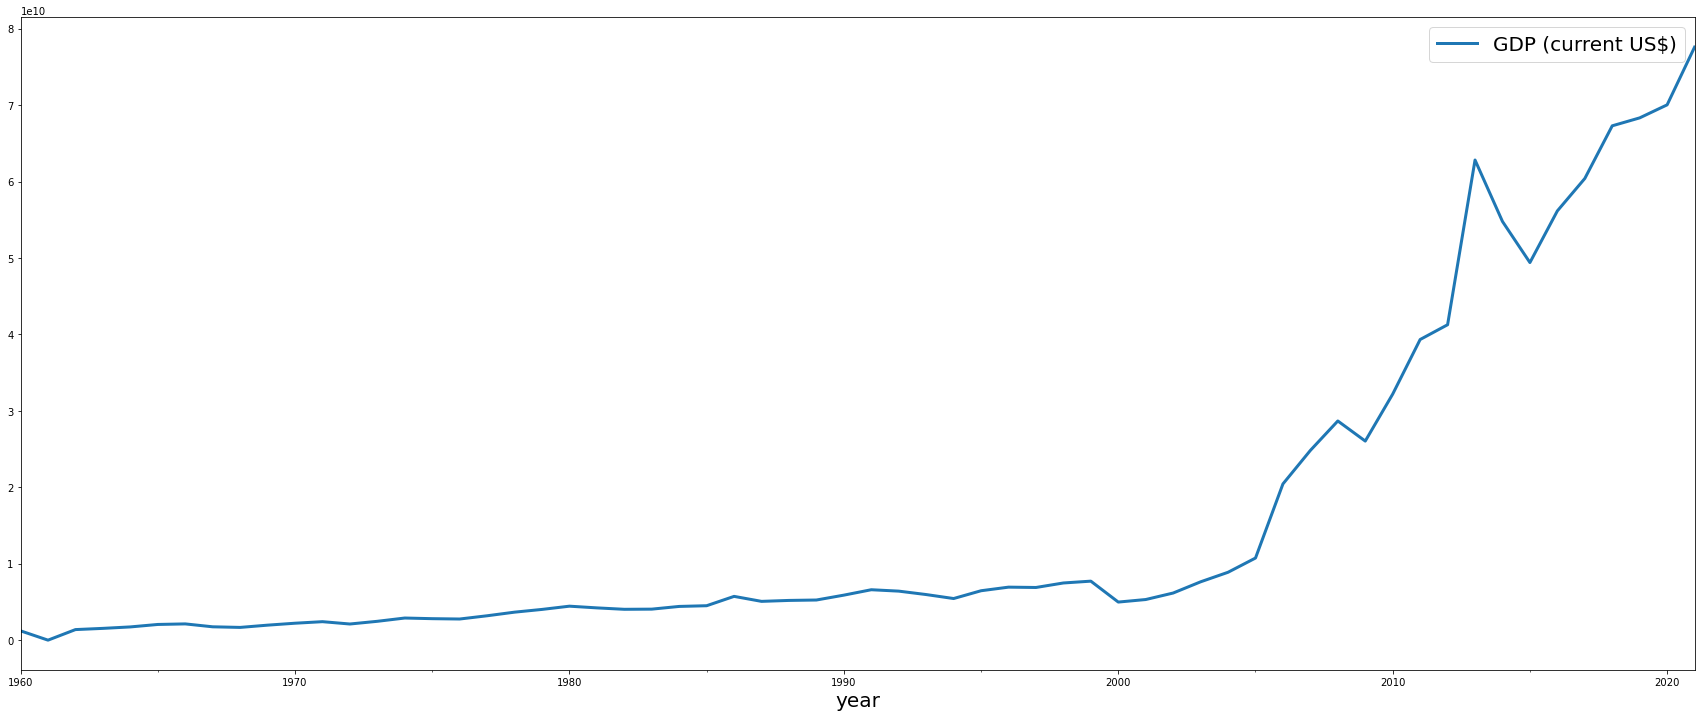

In [3]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

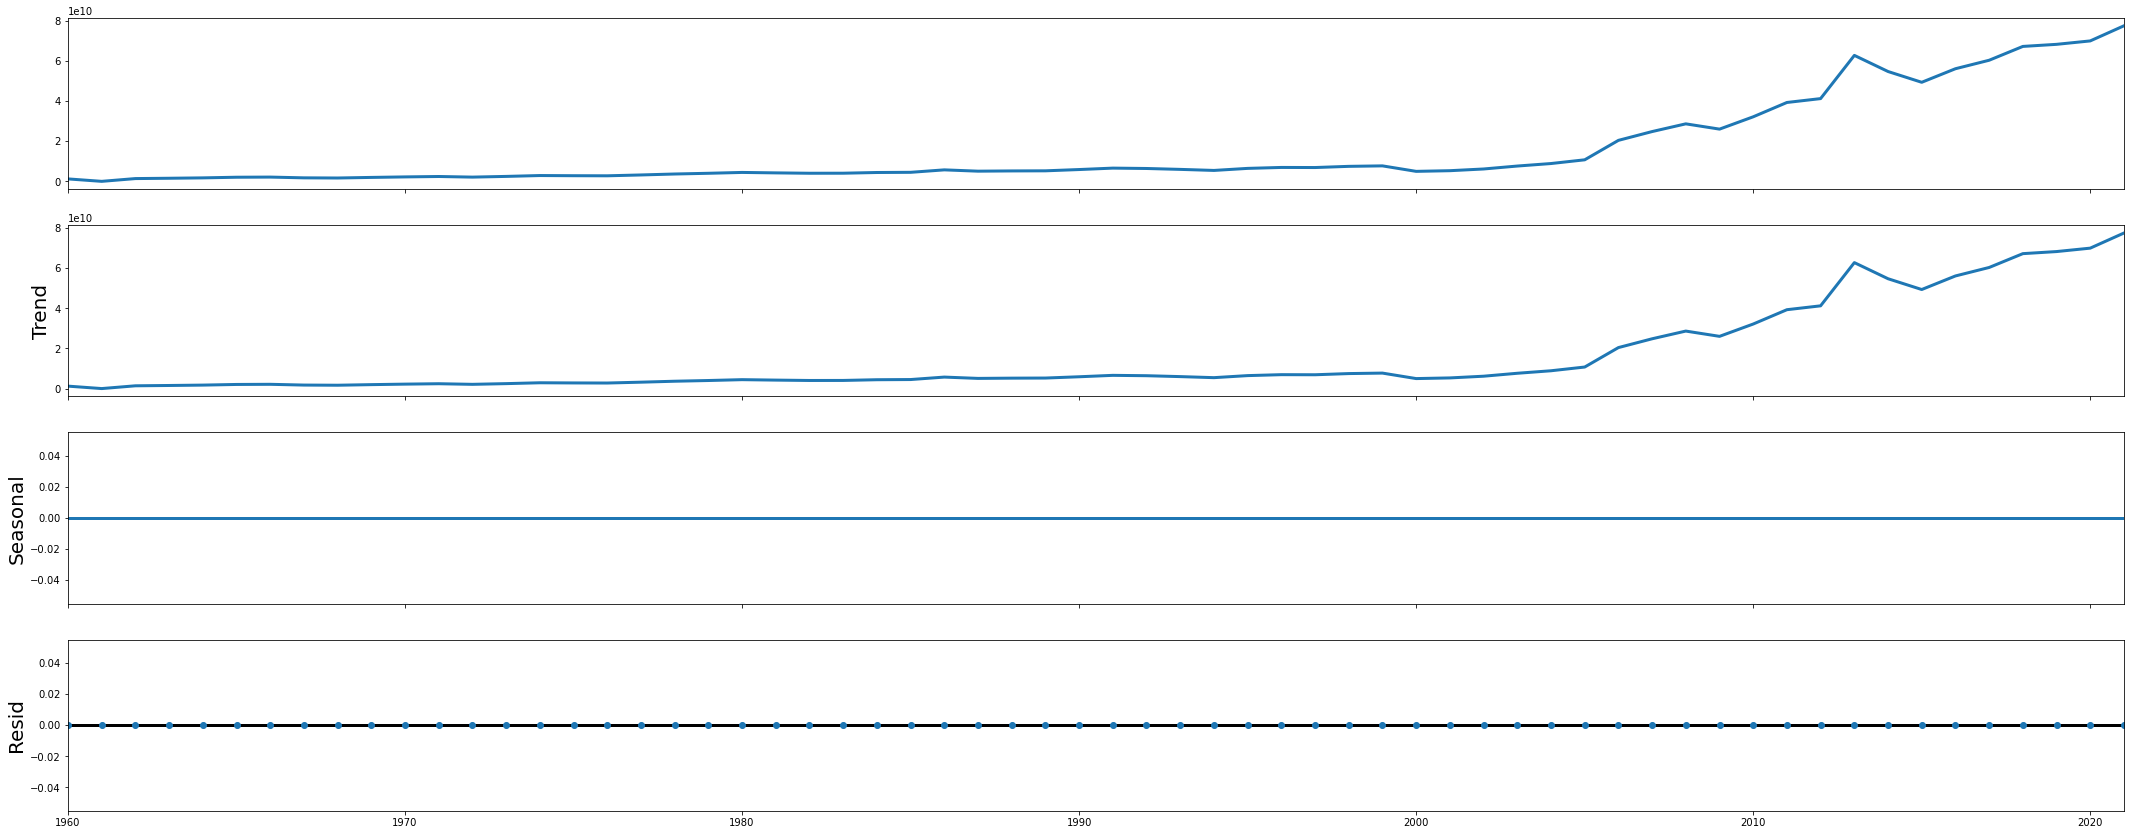

In [4]:
decomposition = seasonal_decompose(data)

fig = decomposition.plot()
plt.show()

По графику видно, что в данных присутствует возрастающий тренд, сезонность находится около 0.

In [5]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

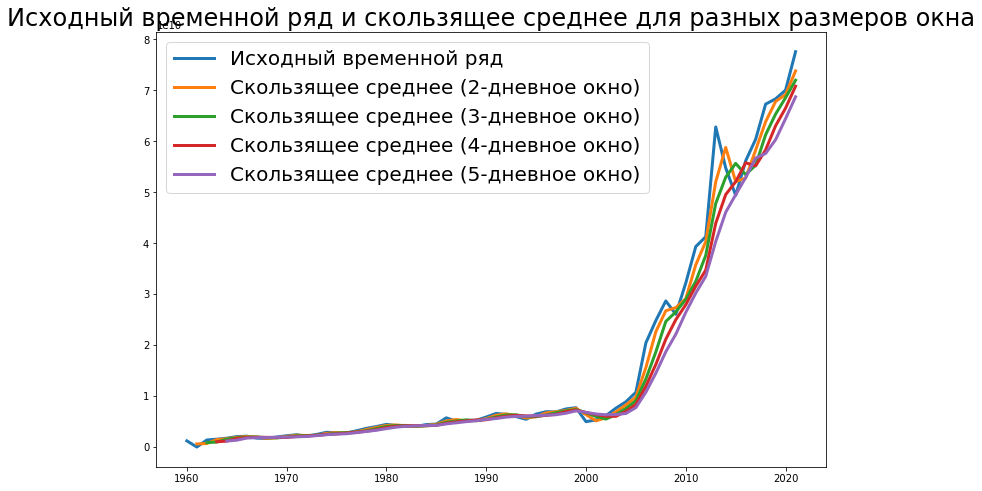

In [6]:
# Размеры окна для скользящего среднего
window_sizes = [2, 3, 4, 5]

# Построение графиков
plt.figure(figsize=(12, 8))
plt.plot(data['GDP (current US$)'], label='Исходный временной ряд')

for window_size in window_sizes:
    ma = data['GDP (current US$)'].rolling(window=window_size).mean()
    plt.plot(ma, label=f'Скользящее среднее ({window_size}-дневное окно)')

plt.legend()
plt.title('Исходный временной ряд и скользящее среднее для разных размеров окна')
plt.show()

По графику видно, что, чем больше окно для сглаживания, тем больше сглаживание временного ряда.

In [7]:
adfuller(train_df["GDP (current US$)"])

(0.6529066974885349,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [8]:
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [9]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=27)
    sgt.plot_pacf(series, ax=axes[1], lags=27, method="ywm")
    plt.show()

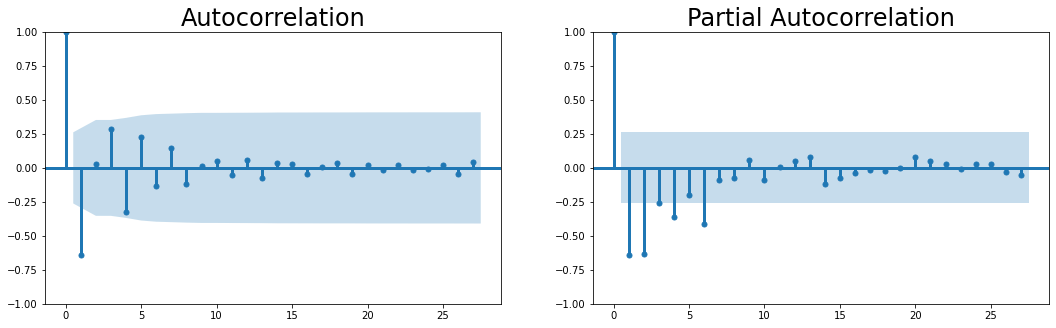

(-4.779623784828512,
 5.9483276402254376e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

In [10]:
plot_acf_pacf(train_df["GDP (current US$)"].diff().diff().diff().dropna())
adfuller(train_df["GDP (current US$)"].diff().diff().diff().dropna())

In [11]:
test2 = adfuller(train_df["GDP (current US$)"].diff().diff().diff().dropna())
print("adf: ", test2[0])
print("p-value: ", test2[1])
print("Critical values: ", test2[4])
if test2[0] > test2[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -4.779623784828512
p-value:  5.9483276402254376e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


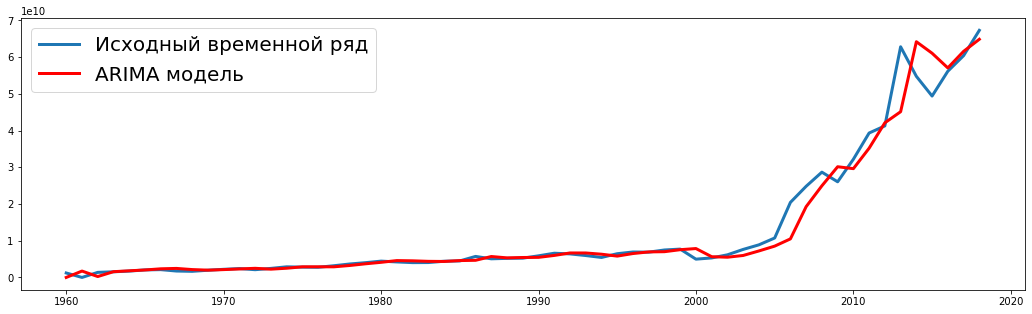

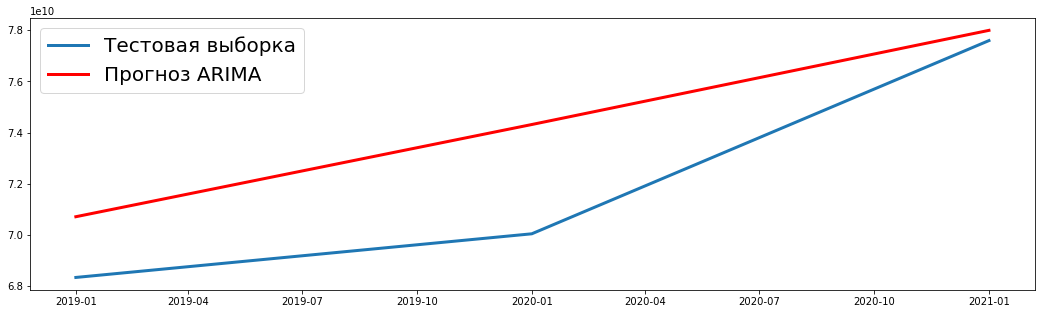

In [12]:
# Построим модель ARIMA с найденными параметрами
arima_model = ARIMA(train_df["GDP (current US$)"], order=(1, 2, 2))
arima_fit = arima_model.fit()

# Визуализация и сравнение с исходным временным рядом
plt.plot(train_df["GDP (current US$)"], label="Исходный временной ряд")
plt.plot(arima_fit.fittedvalues, color='red', label="ARIMA модель")
plt.legend()
plt.show()

# Прогноз для тестовой выборки
forecast = arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

# Оценка качества прогноза
plt.plot(test_df["GDP (current US$)"], label="Тестовая выборка")
plt.plot(forecast, color='red', label="Прогноз ARIMA")
plt.legend()
plt.show()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


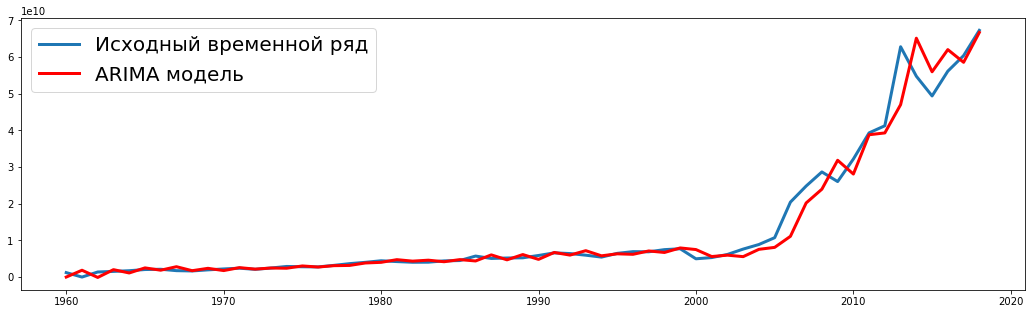

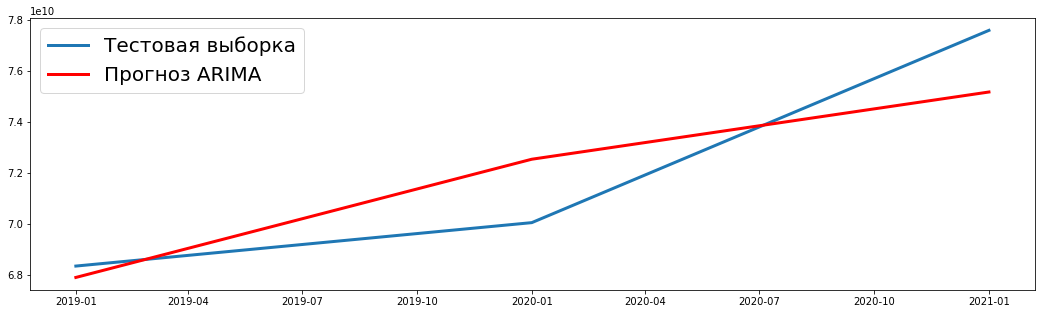

In [13]:
# Найдем оптимальные параметры с помощью pmdarima
auto_model = auto_arima(train_df["GDP (current US$)"], seasonal=False, suppress_warnings=True)
p, d, q = auto_model.order

# Построим модель ARIMA с найденными параметрами
arima_model = ARIMA(train_df["GDP (current US$)"], order=(p, d, q))
arima_fit = arima_model.fit()

# Визуализация и сравнение с исходным временным рядом
plt.plot(train_df["GDP (current US$)"], label="Исходный временной ряд")
plt.plot(arima_fit.fittedvalues, color='red', label="ARIMA модель")
plt.legend()
plt.show()

# Прогноз для тестовой выборки
forecast = arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

# Оценка качества прогноза
plt.plot(test_df["GDP (current US$)"], label="Тестовая выборка")
plt.plot(forecast, color='red', label="Прогноз ARIMA")
plt.legend()
plt.show()

In [14]:
p, d, q = auto_model.order
print(f"Подобранные параметры: p={p}, d={d}, q={q}")

Подобранные параметры: p=1, d=2, q=3


In [15]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 11 Jun 2024   AIC                           2680.765
Time:                        15:47:38   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [16]:
df = data.copy()
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [17]:
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [18]:
missing_values = df.isnull().sum()
print(missing_values)

GDP (current US$)    0
dtype: int64


In [19]:
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [20]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [21]:
# Проверка на пропущенные значения
missing_values = df.isnull().sum()
print("Пропущенные значения:")
print(missing_values)

# Проверка на бесконечные значения
inf_values = df.isin([np.inf, -np.inf]).sum()
print("\nБесконечные значения:")
print(inf_values)

Пропущенные значения:
GDP (current US$)    0
dtype: int64

Бесконечные значения:
GDP (current US$)    0
dtype: int64


In [22]:
test = adfuller(df["GDP (current US$)"].diff().diff().diff().dropna())
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -5.456208629828435
p-value:  2.578324497204482e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


In [23]:
test_df_i = df.iloc[-3:]
train_df_i = df.iloc[:-3]
train_df_i.shape, test_df_i.shape

((59, 1), (3, 1))

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


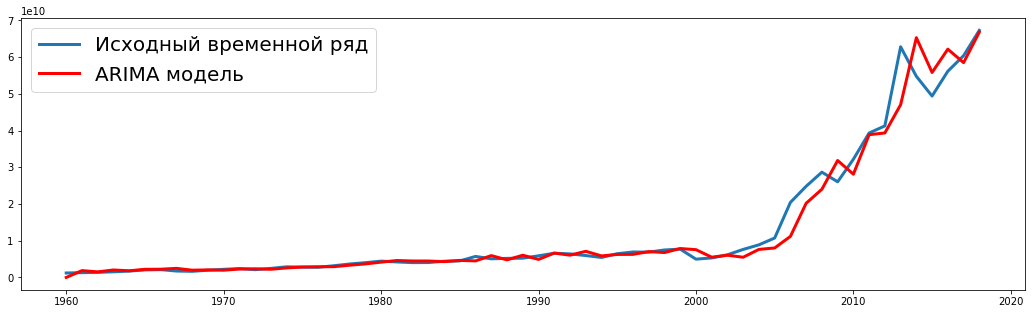

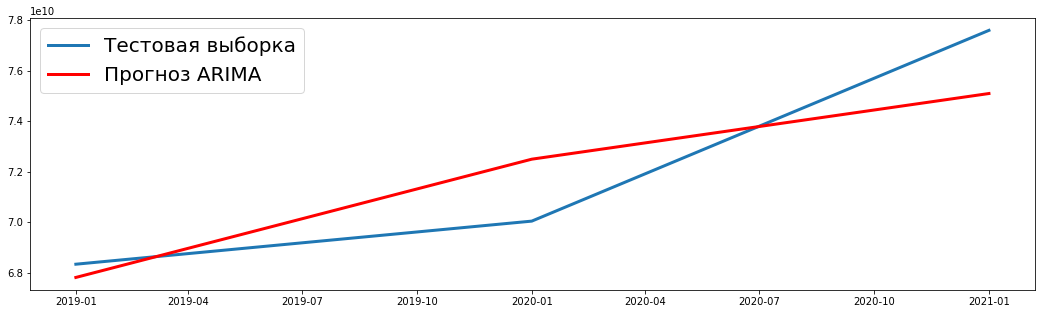

In [24]:
# Найдем оптимальные параметры с помощью pmdarima
auto_model = auto_arima(train_df_i["GDP (current US$)"], seasonal=False, suppress_warnings=True)
p, d, q = auto_model.order

# Построим модель ARIMA с найденными параметрами
arima_model = ARIMA(train_df_i["GDP (current US$)"], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Визуализация и сравнение с исходным временным рядом
plt.plot(train_df_i["GDP (current US$)"], label="Исходный временной ряд")
plt.plot(arima_model_fit.fittedvalues, color='red', label="ARIMA модель")
plt.legend()
plt.show()

# Прогноз для тестовой выборки
forecast = arima_model_fit.predict(start=len(train_df_i), end=len(train_df_i) + len(test_df_i) - 1, typ='levels')

# Оценка качества прогноза
plt.plot(test_df_i["GDP (current US$)"], label="Тестовая выборка")
plt.plot(forecast, color='red', label="Прогноз ARIMA")
plt.legend()
plt.show()

In [25]:
p, d, q = arima_model.order
print(f"Подобранные параметры: p={p}, d={d}, q={q}")

Подобранные параметры: p=1, d=2, q=3


In [26]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Tue, 11 Jun 2024   AIC                           2680.513
Time:                        15:47:44   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [27]:
df_vol = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
df_vol.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [28]:
df_vol.rename(columns={"GDP (current US$)": "gdp"}, inplace=True)
df_vol.asfreq(freq='AS')
import numpy as np
df_vol['gdp'] = df_vol['gdp'].apply(lambda x: np.nan if x==0 else x)
df_vol = df_vol.interpolate()
df_vol['gpd_vol'] = (df_vol.gdp - df_vol.gdp.shift(1))/df_vol.gdp.shift(1)
df_vol['gpd_vol'] = df_vol.gdp.pct_change(1).mul(100).abs()
df_vol['gpd_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gpd_vol, dtype: float64

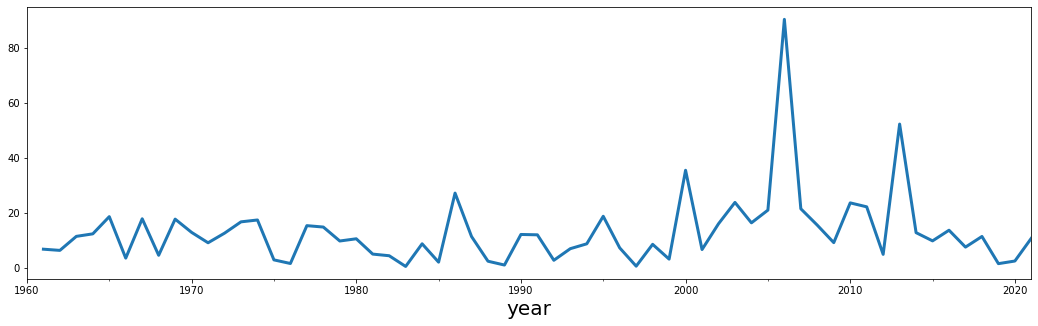

In [29]:
df_vol["gpd_vol"].plot()
plt.show()

In [30]:
test_df_vol = df_vol.loc[df_vol.index[-3]:]
train_df_vol = df_vol.loc[:df_vol.index[-4]]
test_df_vol.head()

,gdp,gpd_vol
year,,
2019-01-01,6.833754e+10,1.542746
2020-01-01,7.004320e+10,2.495937
2021-01-01,7.759428e+10,10.780603


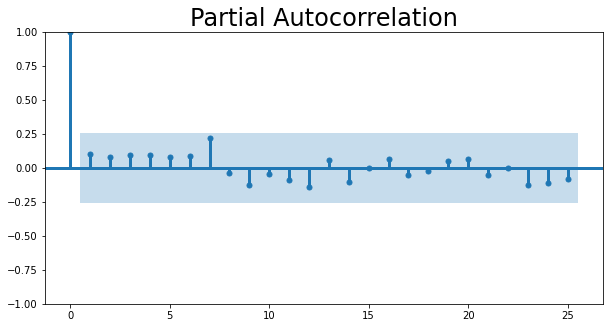

In [31]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df_vol.gpd_vol[1:], lags=25, method="ywm")
plt.show()

In [32]:
adfuller(train_df_vol.gpd_vol[1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [33]:
garch_df = pd.DataFrame(df_vol["gpd_vol"].loc[data.index])
garch_df.loc[train_df_vol.index, "gpd_vol"] = train_df_vol["gpd_vol"].dropna()

In [34]:
from arch import arch_model

model = arch_model(garch_df["gpd_vol"].dropna(), p=2, q=2)

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 228.6095884373151
Iteration:     10,   Func. Count:     74,   Neg. LLF: 226.7262980616956
Iteration:     15,   Func. Count:    109,   Neg. LLF: 226.6994206641058
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978300547896
            Iterations: 19
            Function evaluations: 139
            Gradient evaluations: 19


In [35]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gpd_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           465.196
Method:            Maximum Likelihood   BIC:                           477.558
                                        No. Observations:                   58
Date:                Tue, Jun 11 2024   Df Residuals:                       57
Time:                        15:47:46   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3129      2.221      5.545  2.946e-08 [  7.960, 16.665]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6689     17.107      0.214      0.830 [-29.860, 37.198]
alpha[1]   1.0875e-10      0.107  1.016e-09      1.000 [ -0.210,  0.210]
alpha[2]   3.6529e-07      0.162  2.254e-06      1.000 [ -0.318,  0.318]
beta[1]        1.0000      1.008      0.992      0.321 [ -0.976,  2.976]
beta[2]    3.1769e-07      0.979  3.246e-07      1.000 [ -1.918,  1.918]
========================================================================

Covariance estimator: robust
"""

In [36]:
predictions_df = test_df_vol.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

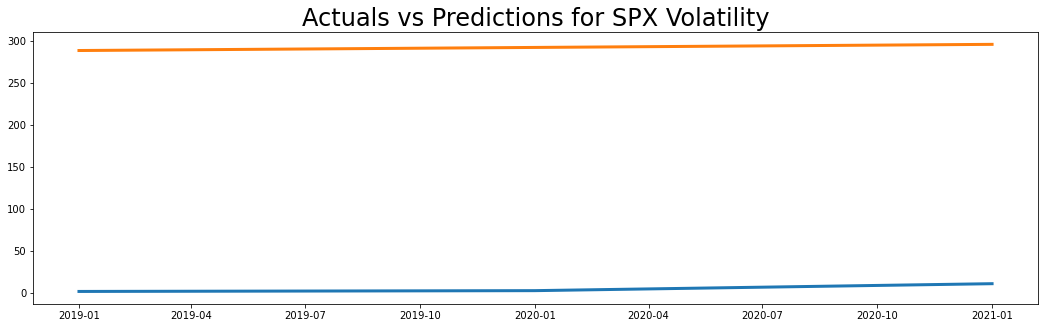

In [37]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gpd_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gpd_vol"].abs(), predictions_df["Predictions"]
)

82483.91549721565

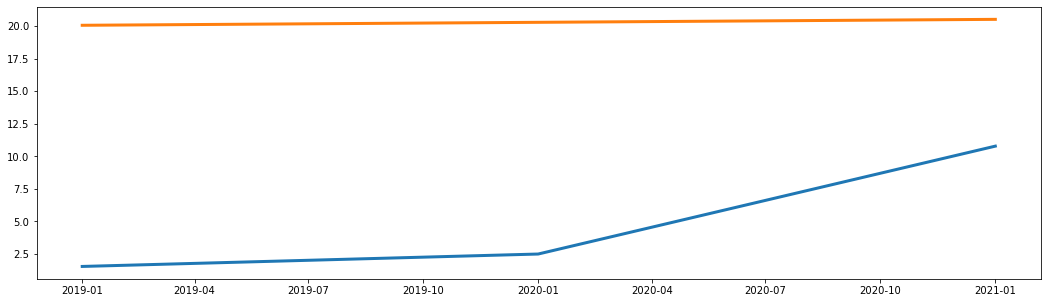

In [39]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df_vol["gpd_vol"].shape[0]))[
    : train_df_vol.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df_vol["gpd_vol"].shape[0]))[
    train_df_vol.shape[0] :
].fillna(0)
y_train = train_df_vol["gpd_vol"].fillna(0)
y_test = test_df_vol["gpd_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()